<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Preprocesamiento de datos y creación de datasets para forecast</h4>
</center>

In [20]:
# Importación librerias

# !pip install awswrangler
# !pip install boto3
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
# Definición fechas

date_start=datetime.strptime('2018-01-01', '%Y-%m-%d')
date_end=datetime.strptime('2019-12-01', '%Y-%m-%d')
forecast_length = 2
date_future=date_end+relativedelta(months=forecast_length)
years=range(2018, 2020)

print(f"Fecha inicio historia {date_start}")
print(f"Fecha fin historia {date_end}")
print(f"Fecha futura (related time series) {date_future}")

# Versión modelo
data_version = '5'
grouped_cols = "product_id"
grouped_cols_name = "product"

Fecha inicio historia 2018-01-01 00:00:00
Fecha fin historia 2019-12-01 00:00:00
Fecha futura (related time series) 2020-02-01 00:00:00


In [4]:
# Conexiones AWS

account_id=boto3.client('sts').get_caller_identity().get('Account')
session = boto3.Session() 
forecast = session.client(service_name='forecast')
region = forecast.meta.region_name
forecastquery = session.client(service_name='forecastquery')

In [5]:
# Buckets de datos

target_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/target/df_ventas_{grouped_cols_name}.csv'
items_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/product/df_products.csv'
related_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/related/df_related_{grouped_cols_name}.csv'

In [6]:
# Verificar comunicación con Amazon Forecast
assert forecast.list_predictors()

### Procesamiento de datos de ventas

- Skus a predecir

In [7]:
skus_a_predecir = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/productos_a_predecir.txt", delimiter='\t')
skus_a_predecir = skus_a_predecir.product_id.to_list()

- Datos de ventas

In [8]:
df_ventas = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/sell-in.txt", delimiter='\t')
df_ventas['periodo'] = df_ventas['periodo'].astype(str)
df_ventas['periodo'] = pd.to_datetime(df_ventas['periodo'], format='%Y%m')
df_ventas = df_ventas[df_ventas.product_id.isin(skus_a_predecir)]
df_ventas.head(1)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,2017-01-01,10234,20524,0,2,0.053,0.053


In [9]:
print(f"Cantidad productos finales a predecir: {len(df_ventas.product_id.drop_duplicates())}")

Cantidad productos finales a predecir: 780


In [10]:
df_ventas_product = df_ventas.groupby(["periodo", "product_id"])["tn"].sum().reset_index()
df_ventas_product.head(1)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222


In [11]:
df_ventas_product.isna().sum()

periodo       0
product_id    0
tn            0
dtype: int64

In [12]:
df_ventas_product.tn.sum().round(1) == df_ventas.tn.sum().round(1) 

True

- Estandarizamos

In [15]:
# Función para estandarizar una serie de tiempo
def standardize_series(series):
    mean = series.mean()
    std = series.std()
    standardized_series = (series - mean) / std
    return standardized_series, mean, std

# Función para revertir la estandarización de una serie de tiempo
def reverse_standardization(standardized_series, mean, std):
    reversed_series = standardized_series * std + mean
    return reversed_series

# Estandarizar todas las series de tiempo por product_id
standardized_data = pd.DataFrame()
means = {}
stds = {}
for product_id, group in df_ventas_product.groupby('product_id'):
    series = group['tn']
    standardized_series, mean, std = standardize_series(series)
    
    standardized_data = pd.concat([standardized_data, pd.DataFrame({'periodo': group['periodo'], 'product_id': product_id, 'tn_standardized': standardized_series})])
    
    means[product_id] = mean
    stds[product_id] = std

standardized_data.head(5)
# Revertir la estandarización por product_id
# original_data = pd.DataFrame()
# for product_id, group in standardized_data.groupby('product_id'):
#     standardized_series = group['tn_standardized']
#     mean = means[product_id]
#     std = stds[product_id]
    
#     original_series = reverse_standardization(standardized_series, mean, std)
    
#     original_data = pd.concat([original_data, pd.DataFrame({'periodo': group['periodo'], 'product_id': product_id, 'tn_original': original_series})])

,periodo,product_id,tn_standardized
0,2017-01-01,20001,-1.554852
496,2017-02-01,20001,-2.013541
994,2017-03-01,20001,-0.318592
1495,2017-04-01,20001,-1.101419
1995,2017-05-01,20001,0.348343


In [18]:
standardized_data.tn_standardized.min()

-3.46831140513055

In [19]:
standardized_data.tn_standardized.max()

4.935145793028355

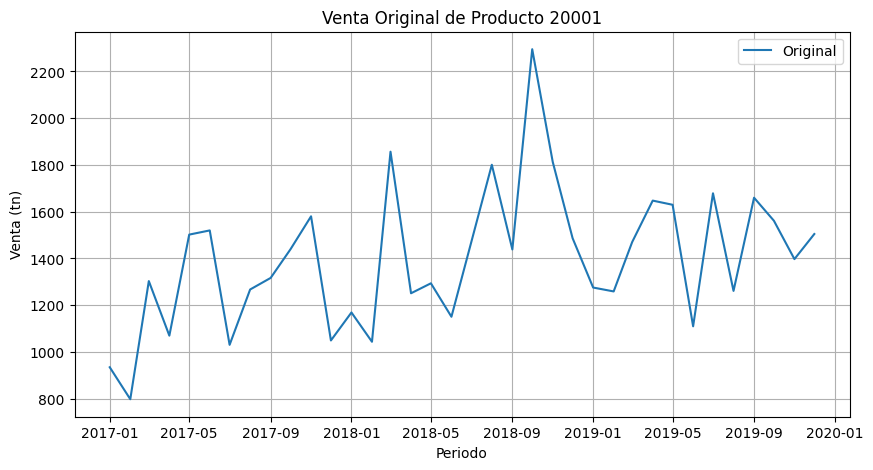

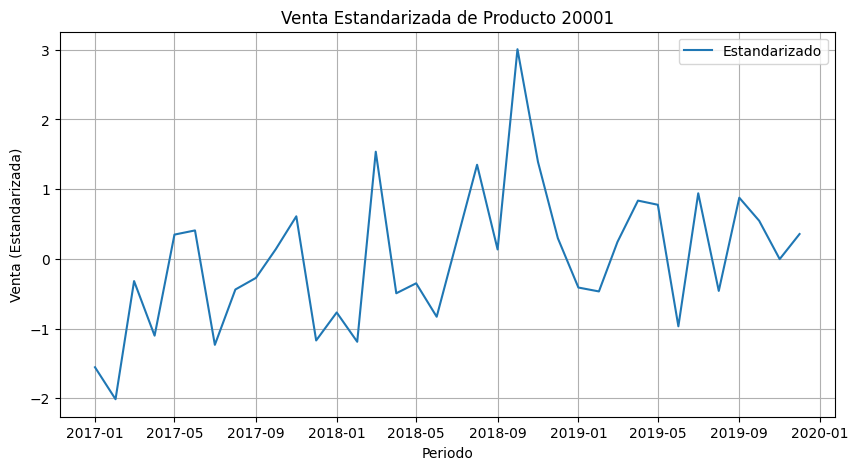

In [26]:
# Seleccionar un producto específico para visualizar
product_id = 20001

# Filtrar los datos para ese producto
df_product = df_ventas_product[df_ventas_product['product_id'] == product_id]

standardized_product = standardized_data[standardized_data['product_id'] == product_id]

# Graficar 'tn' de df_ventas_product
plt.figure(figsize=(10, 5))
plt.plot(df_product['periodo'], df_product['tn'], label='Original')
plt.xlabel('Periodo')
plt.ylabel('Venta (tn)')
plt.title(f'Venta Original de Producto {product_id}')
plt.legend()
plt.grid(True)
plt.show()

# Graficar 'tn_standardized' de standardized_data
plt.figure(figsize=(10, 5))
plt.plot(standardized_product['periodo'], standardized_product['tn_standardized'], label='Estandarizado')
plt.xlabel('Periodo')
plt.ylabel('Venta (Estandarizada)')
plt.title(f'Venta Estandarizada de Producto {product_id}')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Convertir 'means' y 'stds' en un DataFrame
mean_std_df = pd.DataFrame({'product_id': list(means.keys()),
                            'mean': list(means.values()),
                            'std': list(stds.values())})

# Guardar el DataFrame en un archivo CSV
mean_std_df.to_csv('mean_std_by_product.csv', index=False)

In [39]:
standardized_data = standardized_data.rename(columns = {"tn_standardized":"tn"})

- Exportamos

In [33]:
# Exportamos data de ventas product
df_ventas_product_export = standardized_data[(df_ventas_product['periodo']>=date_start) & (df_ventas_product['periodo']<=date_end)]
df_ventas_product_export['product_id'] = df_ventas_product_export['product_id'].astype(str)
print(f"Min periodo {df_ventas_product_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_export.periodo.max()}")
print(f"Tipos por columna: \n{df_ventas_product_export.dtypes}")
wr.s3.to_csv(df_ventas_product_export, target_s3_path, index=False, header=False)

Min periodo 2018-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo            datetime64[ns]
product_id                 object
tn_standardized           float64
dtype: object


{'paths': ['s3://datasets-forecast/modelo-5-forecast-product/target/df_ventas_product.csv'],
 'partitions_values': {}}

### Procesamiento de datos de productos

In [34]:
producto = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/tb_productos.txt", delimiter='\t')
producto.head(5)

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [35]:
print("----ANALISIS DUPLICADOS-----")
print(f"Cantidad productos en maestro productos: {len(producto)}")
print(f"Cantidad productos en maestro productos sin repetidos: {len(producto.product_id.drop_duplicates())}")
# Observamos que product_id duplicados tienen los mismos valores en las otras columnas, son duplicados y procedemos a eliminarlos 
producto = producto.drop_duplicates(subset = "product_id")
print(f"Cantidad productos en maestro productos: {len(producto)}")

----ANALISIS DUPLICADOS-----
Cantidad productos en maestro productos: 1262
Cantidad productos en maestro productos sin repetidos: 1251
Cantidad productos en maestro productos: 1251


In [36]:
producto = producto[producto.product_id.isin(skus_a_predecir)]
print(f"Cantidad productos finales a predecir: {len(producto)}")

Cantidad productos finales a predecir: 780


In [37]:
producto = producto[["product_id", "cat1", "cat2", "cat3", "brand", "sku_size"]]
producto['product_id'] = producto['product_id'].astype(str)
print(f"Tipos por columna \n{producto.dtypes}")
wr.s3.to_csv(producto, items_s3_path, index=False, header=False)

Tipos por columna 
product_id    object
cat1          object
cat2          object
cat3          object
brand         object
sku_size       int64
dtype: object


{'paths': ['s3://datasets-forecast/modelo-5-forecast-product/product/df_products.csv'],
 'partitions_values': {}}

### Procesamiento de datos relacionados

In [66]:
def create_future_periods(df):
    combination = df.groupby([i for i in ['product_id']])["periodo"].apply(lambda s: pd.date_range(s.min(), date_future, freq='MS')).explode().reset_index()
    result = pd.merge(combination, df, how = "left", on = ["periodo", "product_id"])
    result = result[["periodo", "product_id", "tn"]]
    return result

In [67]:
df_related_product_v1 = create_future_periods(standardized_data[standardized_data.periodo >= date_start])
df_related_product_v1 = df_related_product_v1.drop(columns = "tn")

In [68]:
def time_features(df):
    df_time_features = df.copy()
    # Asegúrate de que la columna 'periodo' esté en formato datetime
    df_time_features['periodo'] = pd.to_datetime(df_time_features['periodo'], format='%Y-%m-%d')
    # Crear las columnas 'mes', 'cuatrimestre' y 'dias del mes"
    df_time_features['month'] = df_time_features['periodo'].dt.month
    df_time_features['quarter'] = df_time_features['periodo'].dt.quarter
    df_time_features['days_in_month']= df_time_features['periodo'].dt.daysinmonth
    return df_time_features

In [69]:
df_related_product_v2 = time_features(df_related_product_v1)

In [70]:
# Cantidad de domingos al mes
sundays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start), end=date_future + pd.offsets.MonthEnd(0)))
# sundays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start) - pd.DateOffset(years=1), end=date_future + pd.offsets.MonthEnd(0)))
sundays.columns = ["fecha"]
sundays["day_week"] = pd.to_datetime(sundays['fecha'], format='%Y-%m-%d').dt.dayofweek
sundays = sundays[sundays.day_week == 6].rename(columns = {"day_week":"sundays"})
sundays = sundays.replace({6:1})
sundays['periodo']=sundays['fecha'].apply(lambda x: x.replace(day=1))
sundays = sundays.groupby(["periodo"])["sundays"].sum().reset_index()
sundays['periodo']=pd.to_datetime(sundays['periodo'], format='%Y-%m-%d')
sundays["sundays"] = sundays["sundays"].astype(int)
# Cantidad de sabados al mes
saturdays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start), end=date_future + pd.offsets.MonthEnd(0)))
# saturdays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start) - pd.DateOffset(years=1), end=date_future + pd.offsets.MonthEnd(0)))
saturdays.columns = ["fecha"]
saturdays["day_week"] = pd.to_datetime(saturdays['fecha'], format='%Y-%m-%d').dt.dayofweek
saturdays = saturdays[saturdays.day_week == 5].rename(columns = {"day_week":"saturdays"})
saturdays = saturdays.replace({5:1})
saturdays['periodo']=saturdays['fecha'].apply(lambda x: x.replace(day=1))
saturdays = saturdays.groupby(["periodo"])["saturdays"].sum().reset_index()
saturdays["saturdays"] = saturdays["saturdays"].astype(int)
saturdays['periodo']=pd.to_datetime(saturdays['periodo'], format='%Y-%m-%d')
# DF conjunto
sundays_saturdays = pd.merge(sundays, saturdays, how = "inner", on = "periodo")
sundays_saturdays.head(5)

,periodo,sundays,saturdays
0,2018-01-01,4,4
1,2018-02-01,4,4
2,2018-03-01,4,5
3,2018-04-01,5,4
4,2018-05-01,4,4


In [71]:
df_related_product_v3 = pd.merge(df_related_product_v2, sundays_saturdays, how = "left", on = "periodo")

In [72]:
df_related_product_v3.head(3)

,periodo,product_id,month,quarter,days_in_month,sundays,saturdays
0,2018-01-01,20001,1,1,31,4,4
1,2018-02-01,20001,2,1,28,4,4
2,2018-03-01,20001,3,1,31,4,5


In [73]:
# Exportamos data relacionada, apertura por product
# Nos aseguramos que cada serie temporal (por producto) comience en el mismo periodo que comienza en la serie de tiempo ppal de ventas
df_min_period = df_related_product_v3.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_periodo"})
df_min_period["product_id"] = df_min_period["product_id"].astype(str)
df_related_product_v3['product_id'] = df_related_product_v3['product_id'].astype(str)
df_related_product_export = pd.merge(df_related_product_v3, df_min_period, on='product_id')
df_related_product_export = df_related_product_export[df_related_product_export['periodo'] >= df_related_product_export['min_periodo']]
df_related_product_export = df_related_product_export.drop(columns=['min_periodo'])
df_related_product_export = df_related_product_export[(df_related_product_export['periodo']>=date_start)&(df_related_product_export['periodo']<=date_future)]
print("-------------------------")
print(f"Min periodo {df_related_product_export.periodo.min()}")
print(f"Max periodo {df_related_product_export.periodo.max()}")
print(f"Cantidad de productos {len(df_related_product_export.product_id.unique())}")
print("-------------------------")
print(f"Tipos por columna \n{df_related_product_export.dtypes}")
print("-------------------------")
print(f"Cantidad de NAN values \n{df_related_product_export.isna().sum()}")
print("-------------------------")
wr.s3.to_csv(df_related_product_export, related_s3_path, index=False, header=False)

-------------------------
Min periodo 2018-01-01 00:00:00
Max periodo 2020-02-01 00:00:00
Cantidad de productos 780
-------------------------
Tipos por columna 
periodo          datetime64[ns]
product_id               object
month                     int32
quarter                   int32
days_in_month             int32
sundays                   int32
saturdays                 int32
dtype: object
-------------------------
Cantidad de NAN values 
periodo          0
product_id       0
month            0
quarter          0
days_in_month    0
sundays          0
saturdays        0
dtype: int64
-------------------------


{'paths': ['s3://datasets-forecast/modelo-5-forecast-product/related/df_related_product.csv'],
 'partitions_values': {}}

Chequear que cada combinacion en el df relacionado comience en misma fecha que en df principal para evitar errores en entrenamiento

In [74]:
fecha_min_ventas = df_ventas_product_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_ventas"})
fecha_min_related = df_related_product_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_related"})
merge_fecha_min = pd.merge(fecha_min_ventas, fecha_min_related, how = "outer", on = "product_id")
merge_fecha_min[merge_fecha_min.min_period_ventas != merge_fecha_min.min_period_related]

,product_id,min_period_ventas,min_period_related
